# Fall 2021 CS543/ECE549 Projects

## Grading of Diabetic Retinopathy Severity Level


In [1]:
import numpy as np 
import pandas as pd
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from keras import backend as K
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from glob import glob

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# References: https://www.kaggle.com/varunsharmaml/vgg16-dr
# https://www.kaggle.com/swethapailla/machinevision-capsnet-dr

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# EDA

In [5]:
from keras.utils.np_utils import to_categorical

y = pd.read_csv('data\\trainLabels_cropped.csv')
y['filenames'] = [i+".jpeg" for i in y['image'].values]
#y['level'] = y['level'].map(lambda x: to_categorical(x, 1+y['level'].max()))
y.head()


,Unnamed: 0,Unnamed: 0.1,image,level,filenames
0,0,0,10_left,0,10_left.jpeg
1,1,1,10_right,0,10_right.jpeg
2,2,2,13_left,0,13_left.jpeg
3,3,3,13_right,0,13_right.jpeg
4,4,4,15_left,1,15_left.jpeg


0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

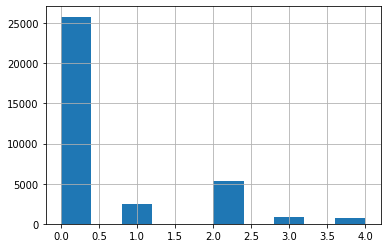

In [6]:
y['level'].hist()
y['level'].value_counts()

In [7]:
y['level'].value_counts()[4]

708

y = y.groupby(['level']).apply(lambda x: x.sample(y['level'].value_counts()[4], replace = True)
                                                      ).reset_index(drop = True)

y['level'].hist(figsize = (10, 5))

# Preparing & Preprocessing Data

In [8]:
y = y[['image', 'level', 'filenames']]

In [9]:
y.head()

,image,level,filenames
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg


In [10]:
train_y, val_y = train_test_split(y, test_size=0.3)
val_y, test_y = train_test_split(val_y, test_size=1.0/3.0)

train_y.shape, val_y.shape, test_y.shape

((24575, 3), (7022, 3), (3511, 3))

In [11]:
train_y['level'].value_counts()


0    18044
2     3720
1     1712
3      594
4      505
Name: level, dtype: int64

<AxesSubplot:>

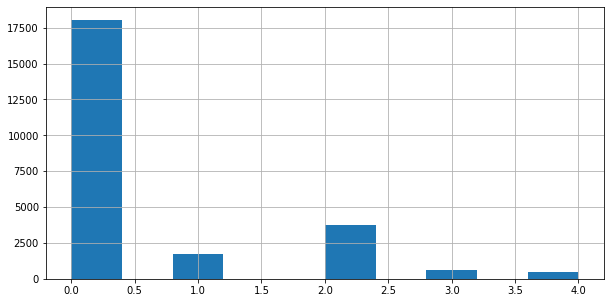

In [12]:
train_y['level'].hist(figsize = (10, 5))
#plt.show()

In [13]:
input_size = (300,300,3)

def load_ben_color(image, sigmaX=input_size[0]/10):
    
    image = image.astype(dtype=np.uint8)
    image = cv2.resize(image, input_size[:-1])
    image = cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return image

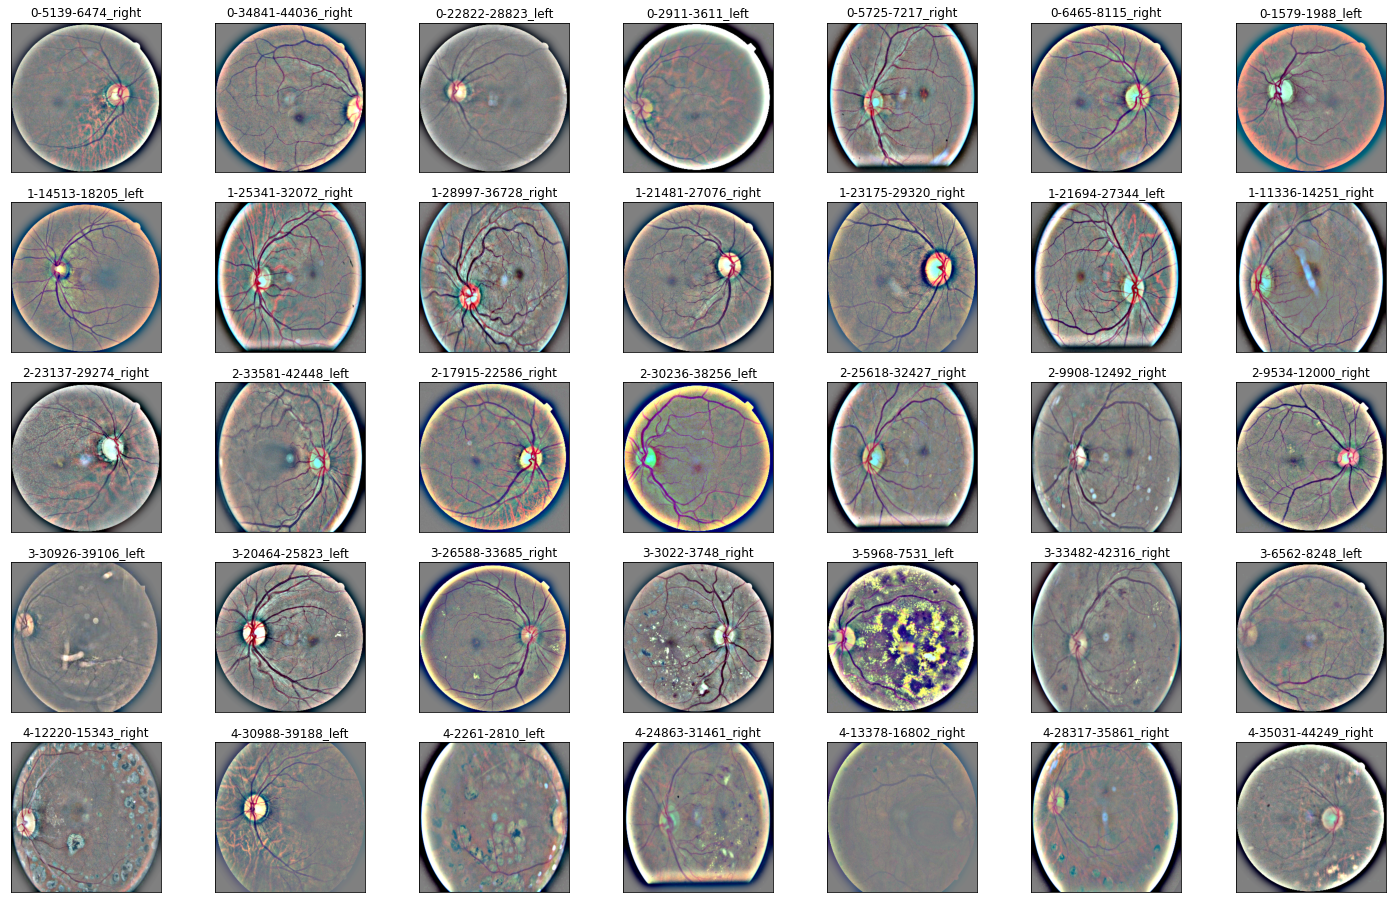

In [14]:
# References: https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#3.A-Important-Update-on-Color-Version-of-Cropping-&-Ben's-Preprocessing

NUM_SAMP=7
dir = "data\\resized_train_cropped\\resized_train_cropped\\"
fig = plt.figure(figsize=(25, 16))

for class_id in sorted(y['level'].unique()):
    for i, (idx, row) in enumerate(y.loc[y['level'] == class_id].sample(NUM_SAMP).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        
        path=dir + f"{row['image']}.jpeg"
        #print(path)
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        image = load_ben_color(image,sigmaX=10)
        
        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )

(768, 1024, 3)


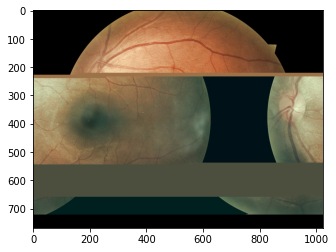

In [15]:
image = cv2.imread(dir + "27369_left.jpeg")
print(image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.show()

In [16]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://arxiv.org/pdf/1409.1556.pdf


batch_size = 20

data_gen_args_train = load_ben_color

data_gen_args_test = load_ben_color





datagen_train = ImageDataGenerator(
                                   shear_range=0.1,
                                   zoom_range= 0.1,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   preprocessing_function = data_gen_args_train)
datagen_val_test = ImageDataGenerator(preprocessing_function = data_gen_args_test)







train_gen = datagen_train.flow_from_dataframe(
                                            dataframe = train_y, directory='data\\resized_train_cropped\\resized_train_cropped', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=input_size[:-1], color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=batch_size, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True
                                        )

val_gen = datagen_val_test.flow_from_dataframe(
                                            dataframe = val_y, directory='data\\resized_train_cropped\\resized_train_cropped', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=input_size[:-1], color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=batch_size, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True, 
                                        )

test_gen = datagen_val_test.flow_from_dataframe(
                                            dataframe = test_y, directory='data\\resized_train_cropped\\resized_train_cropped', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=input_size[:-1], color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=batch_size, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True, 
                                        )






Found 24575 validated image filenames.
Found 7022 validated image filenames.
Found 3511 validated image filenames.


model.fit(
        train_gen,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=val_gen,
        validation_steps=800)


# VGG 16 & VGG 19

In [17]:

dir_0 = 'pretrained_weights\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
dir_1 = 'pretrained_weights\\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'





'''
M0 = DenseNet121(
    include_top=False, weights=dir_0, input_tensor=None,
    input_shape=input_size,
    classifier_activation='softmax'
)

M1 = DenseNet169(
    include_top=False, weights=dir_1, input_tensor=None,
    input_shape=input_size,
    classifier_activation='softmax'
)
'''



M0_og = DenseNet121(
    include_top=False, weights=None, input_tensor=None,
    input_shape=input_size, pooling=None
    
)

M1_og = DenseNet169(
    include_top=False, weights=None, input_tensor=None,
    input_shape=input_size, pooling=None
    
)






In [18]:
M0_og.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [19]:
M1_og.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv5_block17_0_relu (Activatio (None, 9, 9, 1152)   0           conv5_block17_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block17_1_conv (Conv2D)   (None, 9, 9, 128)    147456      conv5_block17_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block17_1_bn (BatchNormal (None, 9, 9, 128)    512         conv5_block17_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block17_1_relu (Activatio (None, 9, 9, 128)    0           conv5_block17_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block17_2_conv (Conv2D)   (None, 9, 9, 32)     36864       conv5_block17_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_bloc

M0.summary()

M1.summary()

In [20]:
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

from tensorflow.keras.layers import *

def build_model(model, n_labels, transfer):
    
    
    x = model.layers[-2].output
    output = Dense(units=n_labels, activation='softmax')(x)
    model = Model(inputs=model.input, outputs=output)
    
    if transfer:
        for layer in model.layers[:12]:
            layer.trainable = False
    
    
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def build_model_non_top(model, n_labels, transfer):
    
    
    x = model.layers[-1].output
    x = Flatten()(x)
    x = Dense(units=64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    '''
    x = Flatten()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(units=512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    '''
    output = Dense(units=n_labels, activation='softmax')(x)
    model = Model(inputs=model.input, outputs=output)
    
    if transfer:
        for layer in model.layers[:12]:
            layer.trainable = False
    
    
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model





transfer = False

In [21]:
M0 = build_model_non_top(M0_og, 5,transfer)
M0.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

M1 = build_model_non_top(M1_og, 5,transfer )
M1.summary()

In [22]:
model_chk_0 = ModelCheckpoint("output\\model_0.h5", save_best_only=True, monitor="val_accuracy")
model_chk_1 = ModelCheckpoint("output\\model_1.h5", save_best_only=True, monitor="val_accuracy")

steps_per_epoch = train_gen.n // batch_size
validation_steps = val_gen.n // batch_size
epochs = 15



H0 = M0.fit(train_gen, steps_per_epoch = steps_per_epoch,
                    validation_data=val_gen, validation_steps=validation_steps,
                    epochs=epochs, workers=4, callbacks=[model_chk_0])
'''


H1 = M1.fit_generator(train_gen, steps_per_epoch = steps_per_epoch,
                    validation_data=val_gen, validation_steps=validation_steps,
                    epochs=epochs, workers=4, callbacks=[model_chk_1])

'''

Epoch 1/15
1228/1228 [==============================] - 1115s 892ms/step - loss: 1.2946 - accuracy: 0.5589 - val_loss: 0.9370 - val_accuracy: 0.7345
Epoch 2/15
1228/1228 [==============================] - 1030s 837ms/step - loss: 0.9011 - accuracy: 0.7298 - val_loss: 0.9110 - val_accuracy: 0.7316
Epoch 3/15
1228/1228 [==============================] - 1069s 869ms/step - loss: 0.8485 - accuracy: 0.7307 - val_loss: 0.9919 - val_accuracy: 0.7339
Epoch 4/15
1228/1228 [==============================] - 1085s 882ms/step - loss: 0.8176 - accuracy: 0.7341 - val_loss: 1.3793 - val_accuracy: 0.7340
Epoch 5/15
1228/1228 [==============================] - 1095s 890ms/step - loss: 0.7881 - accuracy: 0.7409 - val_loss: 0.9775 - val_accuracy: 0.6707
Epoch 6/15
1228/1228 [==============================] - 1065s 866ms/step - loss: 0.7673 - accuracy: 0.7452 - val_loss: 0.9424 - val_accuracy: 0.7340
Epoch 7/15
1228/1228 [==============================] - 1042s 847ms/step - loss: 0.7548 - accuracy: 0.7502

'\n\n\nH1 = M1.fit_generator(train_gen, steps_per_epoch = steps_per_epoch,\n                    validation_data=val_gen, validation_steps=validation_steps,\n                    epochs=epochs, workers=4, callbacks=[model_chk_1])\n\n'

In [23]:
'''
H0 = M0.fit_generator(train_gen, steps_per_epoch = steps_per_epoch,
                    validation_data=val_gen, validation_steps=validation_steps,
                    epochs=epochs, workers=4, callbacks=[model_chk_0])
'''

'\nH0 = M0.fit_generator(train_gen, steps_per_epoch = steps_per_epoch,\n                    validation_data=val_gen, validation_steps=validation_steps,\n                    epochs=epochs, workers=4, callbacks=[model_chk_0])\n'

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from prettytable import PrettyTable
# Test model using test dataset
def test(model, y_test, test_gen):
    
    x_test = test_gen
    y_pred = model.predict(x_test, batch_size=100)
    print("Groud Truth values: ",y_test.shape)
    print(y_test)
    print('-'*40)
    print("Predicted values: ",y_pred.shape)
    print(y_pred)
    pred = np.argmax(y_pred, axis=1)
    test = np.argmax(y_test, axis=1)
    #pred = y_pred.round()
    #test = y_test.round()
    accuracy = (np.sum(np.argmax(y_pred, 1) == np.argmax(y_test,1))/y_test.shape[0])
    precision = metrics.precision_score(test, pred,average='weighted')
    recall = metrics.recall_score(test, pred,average='weighted')
    f1 = metrics.f1_score(test, pred,average='weighted')
    print(" ")
    Cnn_Table = PrettyTable(['vgg Performance Metrics', '%'])
  
    # Add rows
    Cnn_Table.add_row(['Accuracy ',accuracy])
    Cnn_Table.add_row(['Precision',precision])
    Cnn_Table.add_row(['Recall/Sensitivity   ',recall])
    Cnn_Table.add_row(['F1_score ',f1])
    #myTable.add_row(['MLP_Confusion_Matrix',matrix])

    print(Cnn_Table)

    #Confusion Matrix
    print(" ")
    matrix = metrics.confusion_matrix(test, pred)
    print(" ")
    print('vgg_Confusion_Matrix:')
    print(" ")
    print(matrix)
    print(" ")
    
    print("classification_report: ")
    print('-'*40)
    print(metrics.classification_report(test, pred))
    
    
   
    
    # Plotting ROC curve
    y = y_test
    # Binarize the output
    y = label_binarize(y, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC for specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to specific class')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' ')
    
    # Plot ROC curve for multi class
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
print("Model is ready to Test")

Model is ready to Test


In [25]:
test_y['level'].values

array([0, 0, 1, ..., 2, 0, 2], dtype=int64)

In [26]:
from tensorflow.keras.utils import to_categorical

y_test = test_y['level'].map(lambda x: to_categorical(x, 5))
y_test = np.asarray(list(y_test))
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

Groud Truth values:  (3511, 5)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
----------------------------------------
Predicted values:  (3511, 5)
[[0.72643083 0.11406174 0.1431263  0.01508879 0.00129234]
 [0.4155709  0.18527046 0.3174974  0.07323566 0.0084255 ]
 [0.3102049  0.2272453  0.37521416 0.07838876 0.00894686]
 ...
 [0.6383122  0.20080312 0.1473329  0.01178407 0.00176769]
 [0.4792805  0.18802837 0.30158713 0.02643886 0.00466505]
 [0.3335169  0.17133275 0.38062027 0.10163064 0.01289945]]
 
+-------------------------+--------------------+
| vgg Performance Metrics |         %          |
+-------------------------+--------------------+
|        Accuracy         | 0.5770435773283965 |
|        Precision        | 0.577840916624049  |
|  Recall/Sensitivity     | 0.5770435773283965 |
|        F1_score         | 0.5730944384206134 |
+-------------------------+--------------------+
 
 
vgg_Confusion_Matrix:
 
[[1872   

C:\Users\wangh\anaconda3\envs\tf-30x\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wangh\anaconda3\envs\tf-30x\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wangh\anaconda3\envs\tf-30x\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wangh\anaconda3\envs\tf

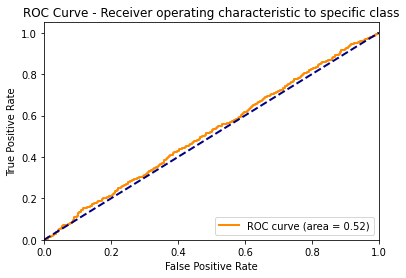

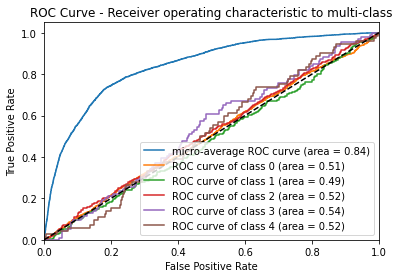

In [29]:
test(M0, y_test, test_gen)

test(M1, y_test, test_gen)

In [ ]:
#M0.evaluate_generator(test_gen, steps=test_gen.n/batch_size, verbose=1)

In [30]:
M0.evaluate_generator(test_gen, steps=test_gen.n/batch_size, verbose=1)

C:\Users\wangh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


175/175 [==============================] - 270s 2s/step - loss: 0.9127 - accuracy: 0.6571


[0.9126855731010437, 0.6570777297019958]

Plot History

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()